https://gluon.mxnet.io/chapter08_computer-vision/fine-tuning.html

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Demo mode uses the validation dataset for training, which is smaller and faster to train.
demo = True
log_interval = 100
gpus = 0

# Options are imperative or hybrid. Use hybrid for better performance.
mode = 'hybrid'

# training hyperparameters
# large batch size (e.g. 256) only on bigger machines, ~5 for local laptop
batch_size = 5
if demo:
    epochs = 5
    learning_rate = 0.02
    wd = 0.002
else:
    epochs = 40
    learning_rate = 0.05
    wd = 0.002

# the class weight for hotdog class to help the imbalance problem.
positive_class_weight = 5

num_workers = 1

In [3]:
from __future__ import print_function
import logging
logging.basicConfig(level=logging.INFO)
import os
import time
from collections import OrderedDict
import skimage.io as io

import mxnet as mx
from mxnet.test_utils import download
mx.random.seed(127)

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models
from mxnet.gluon.data.vision import transforms

In [4]:
jitter_param = 0.4
lighting_param = 0.1

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(brightness=jitter_param, contrast=jitter_param,
                                 saturation=jitter_param),
    transforms.RandomLighting(lighting_param),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
"""
path = '../'
train_path = os.path.join(path, 'train')
#val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')
val_path = os.path.join(path, 'test')

train_dataset = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_dataset = gluon.data.DataLoader(
    gluon.data.vision.ImageFolderDataset(train_path).transform_first(transform_train),
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

if demo:
    training_dataset, training_data_hash = dataset_files['validation']
else:
    training_dataset, training_data_hash = dataset_files['train']

validation_dataset, validation_data_hash = dataset_files['validation']

def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        logging.warn('Found hash mismatch in file {}, possibly due to incomplete download.'
                     .format(file_path))
    return matched


url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/{}'
if not os.path.exists(training_dataset) or not verified(training_dataset, training_data_hash):
    logging.info('Downloading training dataset.')
    download(url_format.format(training_dataset),
             overwrite=True)
if not os.path.exists(validation_dataset) or not verified(validation_dataset, validation_data_hash):
    logging.info('Downloading validation dataset.')
    download(url_format.format(validation_dataset),
             overwrite=True)


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:344: UserWarning: Ignoring ../train/pos/.ipynb_checkpoints of type . Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))


NameError: name 'dataset_files' is not defined

In [41]:
# load dataset
train_iter = mx.io.ImageRecordIter(path_imgrec=training_dataset,
                                   min_img_size=256,
                                   data_shape=(3, 224, 224),
                                   rand_crop=True,
                                   shuffle=True,
                                   batch_size=batch_size,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)
val_iter = mx.io.ImageRecordIter(path_imgrec=validation_dataset,
                                 min_img_size=256,
                                 data_shape=(3, 224, 224),
                                 batch_size=batch_size)


In [42]:
from mxnet.gluon import nn
from mxnet.gluon.model_zoo import vision as models

# get pretrained squeezenet
net = models.squeezenet1_1(pretrained=True, prefix='deep_dog_')
# hot dog happens to be a class in imagenet.
# we can reuse the weight for that class for better performance
# here's the index for that class for later use
imagenet_helmet_index = 713

In [43]:
deep_helmet_net = models.squeezenet1_1(prefix='deep_helmet_', classes=2)
deep_helmet_net.collect_params().initialize()
deep_helmet_net.features = net.features
print(deep_helmet_net)

SqueezeNet(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(2, 2))
    (1): Activation(relu)
    (2): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=True)
    (3): HybridSequential(
      (0): HybridSequential(
        (0): Conv2D(64 -> 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Activation(relu)
      )
      (1): HybridConcurrent(
        (0): HybridSequential(
          (0): Conv2D(16 -> 64, kernel_size=(1, 1), stride=(1, 1))
          (1): Activation(relu)
        )
        (1): HybridSequential(
          (0): Conv2D(16 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): Activation(relu)
        )
      )
    )
    (4): HybridSequential(
      (0): HybridSequential(
        (0): Conv2D(128 -> 16, kernel_size=(1, 1), stride=(1, 1))
        (1): Activation(relu)
      )
      (1): HybridConcurrent(
        (0): HybridSequential(
          (0): Conv2D(16 -> 64, kernel_size=(1, 1), stride=(1, 1))
      

In [45]:
from skimage.color import rgba2rgb

def classify_helmet(net, url):
    I = io.imread(url)
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    image = mx.nd.array(I).astype(np.uint8)
    plt.subplot(1, 2, 1)
    plt.imshow(image.asnumpy())
    image = mx.image.resize_short(image, 256)
    image, _ = mx.image.center_crop(image, (224, 224))
    plt.subplot(1, 2, 2)
    plt.imshow(image.asnumpy())
    image = mx.image.color_normalize(image.astype(np.float32)/255,
                                     mean=mx.nd.array([0.485, 0.456, 0.406]),
                                     std=mx.nd.array([0.229, 0.224, 0.225]))
    image = mx.nd.transpose(image.astype('float32'), (2,1,0))
    image = mx.nd.expand_dims(image, axis=0)
    out = mx.nd.SoftmaxActivation(net(image))
    print('Probabilities are: '+str(out[0].asnumpy()))
    result = np.argmax(out.asnumpy())
    outstring = ['No helmet!', 'Helmet!']
    print(outstring[result])

Probabilities are: [ 0.59458917  0.4054108 ]
No helmet!


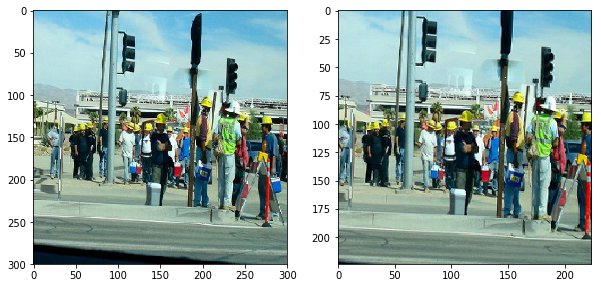

In [47]:
classify_helmet(deep_helmet_net, '../test/pos/112.jpg')



Probabilities are: [ 0.44578007  0.5542199 ]
Helmet!


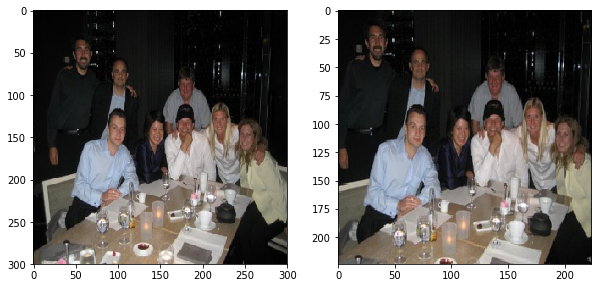

In [49]:
classify_helmet(deep_helmet_net, '../test/neg/1028.jpg')

In [50]:
# let's examine the output layer and find the last conv layer
print(net.output)

HybridSequential(
  (0): Conv2D(512 -> 1000, kernel_size=(1, 1), stride=(1, 1))
  (1): Activation(relu)
  (2): AvgPool2D(size=(13, 13), stride=(13, 13), padding=(0, 0), ceil_mode=False)
  (3): Flatten
)


In [52]:
# the last conv layer is the second layer
pretrained_conv_params = net.output[0].params

# weights can then be found from the above parameter dict
pretrained_weight_param = pretrained_conv_params.get('weight')
pretrained_bias_param = pretrained_conv_params.get('bias')

# next, we locate the right slice that we're interested in.
helmet_w = mx.nd.split(pretrained_weight_param.data().as_in_context(mx.cpu()),
                       1000, axis=0)[imagenet_helmet_index]
helmet_b = mx.nd.split(pretrained_bias_param.data().as_in_context(mx.cpu()),
                       1000, axis=0)[imagenet_helmet_index]

# our classifier is for two classes. here, we reuse the hotdog class weight,
# and randomly initialize the 'not hotdog' class.
new_classifier_w = mx.nd.concat(mx.nd.random_normal(shape=helmet_w.shape, scale=0.02),
                                helmet_w,
                                dim=0)
new_classifier_b = mx.nd.concat(mx.nd.random_normal(shape=helmet_b.shape, scale=0.02),
                                helmet_b,
                                dim=0)

# finally, we initialize the parameter buffers and set the values.
# since classifier is a HybridSequential/Sequential, the following
# takes the zero-indexed 1-st layer of the classifier
final_conv_layer_params = deep_helmet_net.output[0].params
final_conv_layer_params.get('weight').set_data(new_classifier_w)
final_conv_layer_params.get('bias').set_data(new_classifier_b)

In [53]:
# return metrics string representation
def metric_str(names, accs):
    return ', '.join(['%s=%f'%(name, acc) for name, acc in zip(names, accs)])
metric = mx.metric.create(['acc', 'f1'])

In [54]:
import mxnet.gluon as gluon
from mxnet.image import color_normalize

def evaluate(net, data_iter, ctx):
    data_iter.reset()
    for batch in data_iter:
        data = color_normalize(batch.data[0]/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        for x in data:
            outputs.append(net(x))
        metric.update(label, outputs)
    out = metric.get()
    metric.reset()
    return out

In [55]:
import mxnet.autograd as autograd

def train(net, train_iter, val_iter, epochs, ctx):
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': wd})
    loss = gluon.loss.SoftmaxCrossEntropyLoss()

    best_f1 = 0
    val_names, val_accs = evaluate(net, val_iter, ctx)
    logging.info('[Initial] validation: %s'%(metric_str(val_names, val_accs)))
    for epoch in range(epochs):
        tic = time.time()
        train_iter.reset()
        btic = time.time()
        for i, batch in enumerate(train_iter):
            # the model zoo models expect normalized images
            data = color_normalize(batch.data[0]/255,
                                   mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                   std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            data = gluon.utils.split_and_load(data, ctx_list=ctx, batch_axis=0)
            label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
            outputs = []
            Ls = []
            with autograd.record():
                for x, y in zip(data, label):
                    z = net(x)
                    # rescale the loss based on class to counter the imbalance problem
                    L = loss(z, y) * (1+y*positive_class_weight)/positive_class_weight
                    # store the loss and do backward after we have done forward
                    # on all GPUs for better speed on multiple GPUs.
                    Ls.append(L)
                    outputs.append(z)
                for L in Ls:
                    L.backward()
            trainer.step(batch.data[0].shape[0])
            metric.update(label, outputs)
            if log_interval and not (i+1)%log_interval:
                names, accs = metric.get()
                logging.info('[Epoch %d Batch %d] speed: %f samples/s, training: %s'%(
                               epoch, i, batch_size/(time.time()-btic), metric_str(names, accs)))
            btic = time.time()

        names, accs = metric.get()
        metric.reset()
        logging.info('[Epoch %d] training: %s'%(epoch, metric_str(names, accs)))
        logging.info('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
        val_names, val_accs = evaluate(net, val_iter, ctx)
        logging.info('[Epoch %d] validation: %s'%(epoch, metric_str(val_names, val_accs)))

        if val_accs[1] > best_f1:
            best_f1 = val_accs[1]
            logging.info('Best validation f1 found. Checkpointing...')
            net.save_params('deep-helmet-%d.params'%(epoch))

if mode == 'hybrid':
    deep_helmet_net.hybridize()
if epochs > 0:
    #contexts = [mx.cpu()]
    contexts = [mx.gpu(i) for i in range(gpus)] if gpus > 0 else [mx.cpu()]
    deep_helmet_net.collect_params().reset_ctx(contexts)
    train(deep_helmet_net, train_iter, val_iter, epochs, contexts)

INFO:root:[Initial] validation: accuracy=0.208730, f1=0.253789
INFO:root:[Epoch 0 Batch 99] speed: 32.376297 samples/s, training: accuracy=0.460000, f1=0.267762
INFO:root:[Epoch 0 Batch 199] speed: 31.263353 samples/s, training: accuracy=0.334000, f1=0.266857
INFO:root:[Epoch 0] training: accuracy=0.323016, f1=0.260610
INFO:root:[Epoch 0] time cost: 45.513745
INFO:root:[Epoch 0] validation: accuracy=0.606349, f1=0.319463
INFO:root:Best validation f1 found. Checkpointing...


ValueError: Prefix deep_helmet_ is to be striped before saving, but Parameter deep_dog_conv0_weight does not start with deep_helmet_. If you are using Block.save_params, This may be due to your Block shares parameters from other Blocks or you forgot to use ``with name_scope()`` during init. Consider switching to Block.collect_params.save and Block.collect_params.load instead.

In [ ]:
classify_helmet(deep_helmet_net, '../test/pos/112.jpg')

In [ ]:
classify_helmet(deep_helmet_net, '../test/neg/1028.jpg')